# Load Clip

In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-n95nkpvp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-n95nkpvp
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [6]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Sample a few to validate 

In [8]:
import pandas as pd
contract_df = pd.read_csv('top5000contract.csv')

In [9]:
import glob 
imgs = glob.glob('./thumbnail/*')

## Sample 10 Images and their description

In [10]:

from random import seed, sample
seed(1026)
sample_imgs = sample(imgs, 10)

# Get the description
desc = []
for img in sample_imgs:
    contract = img.split('/')[-1].split('.')[0]
    d = contract_df.loc[contract_df['contract_address']==contract, 'desc'].item()
    desc.append(d)


In [11]:
def title_formatter(text, truncate = None):
    words = text.split()
    if truncate:
        words = words[:truncate]
    total_string = ""
    for counter, word in enumerate(words):
        if counter>0 and counter % 5 == 0:
            total_string +="\n{}".format(word)
        else:
            total_string +=" {}".format(word)
    return total_string.lstrip()

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


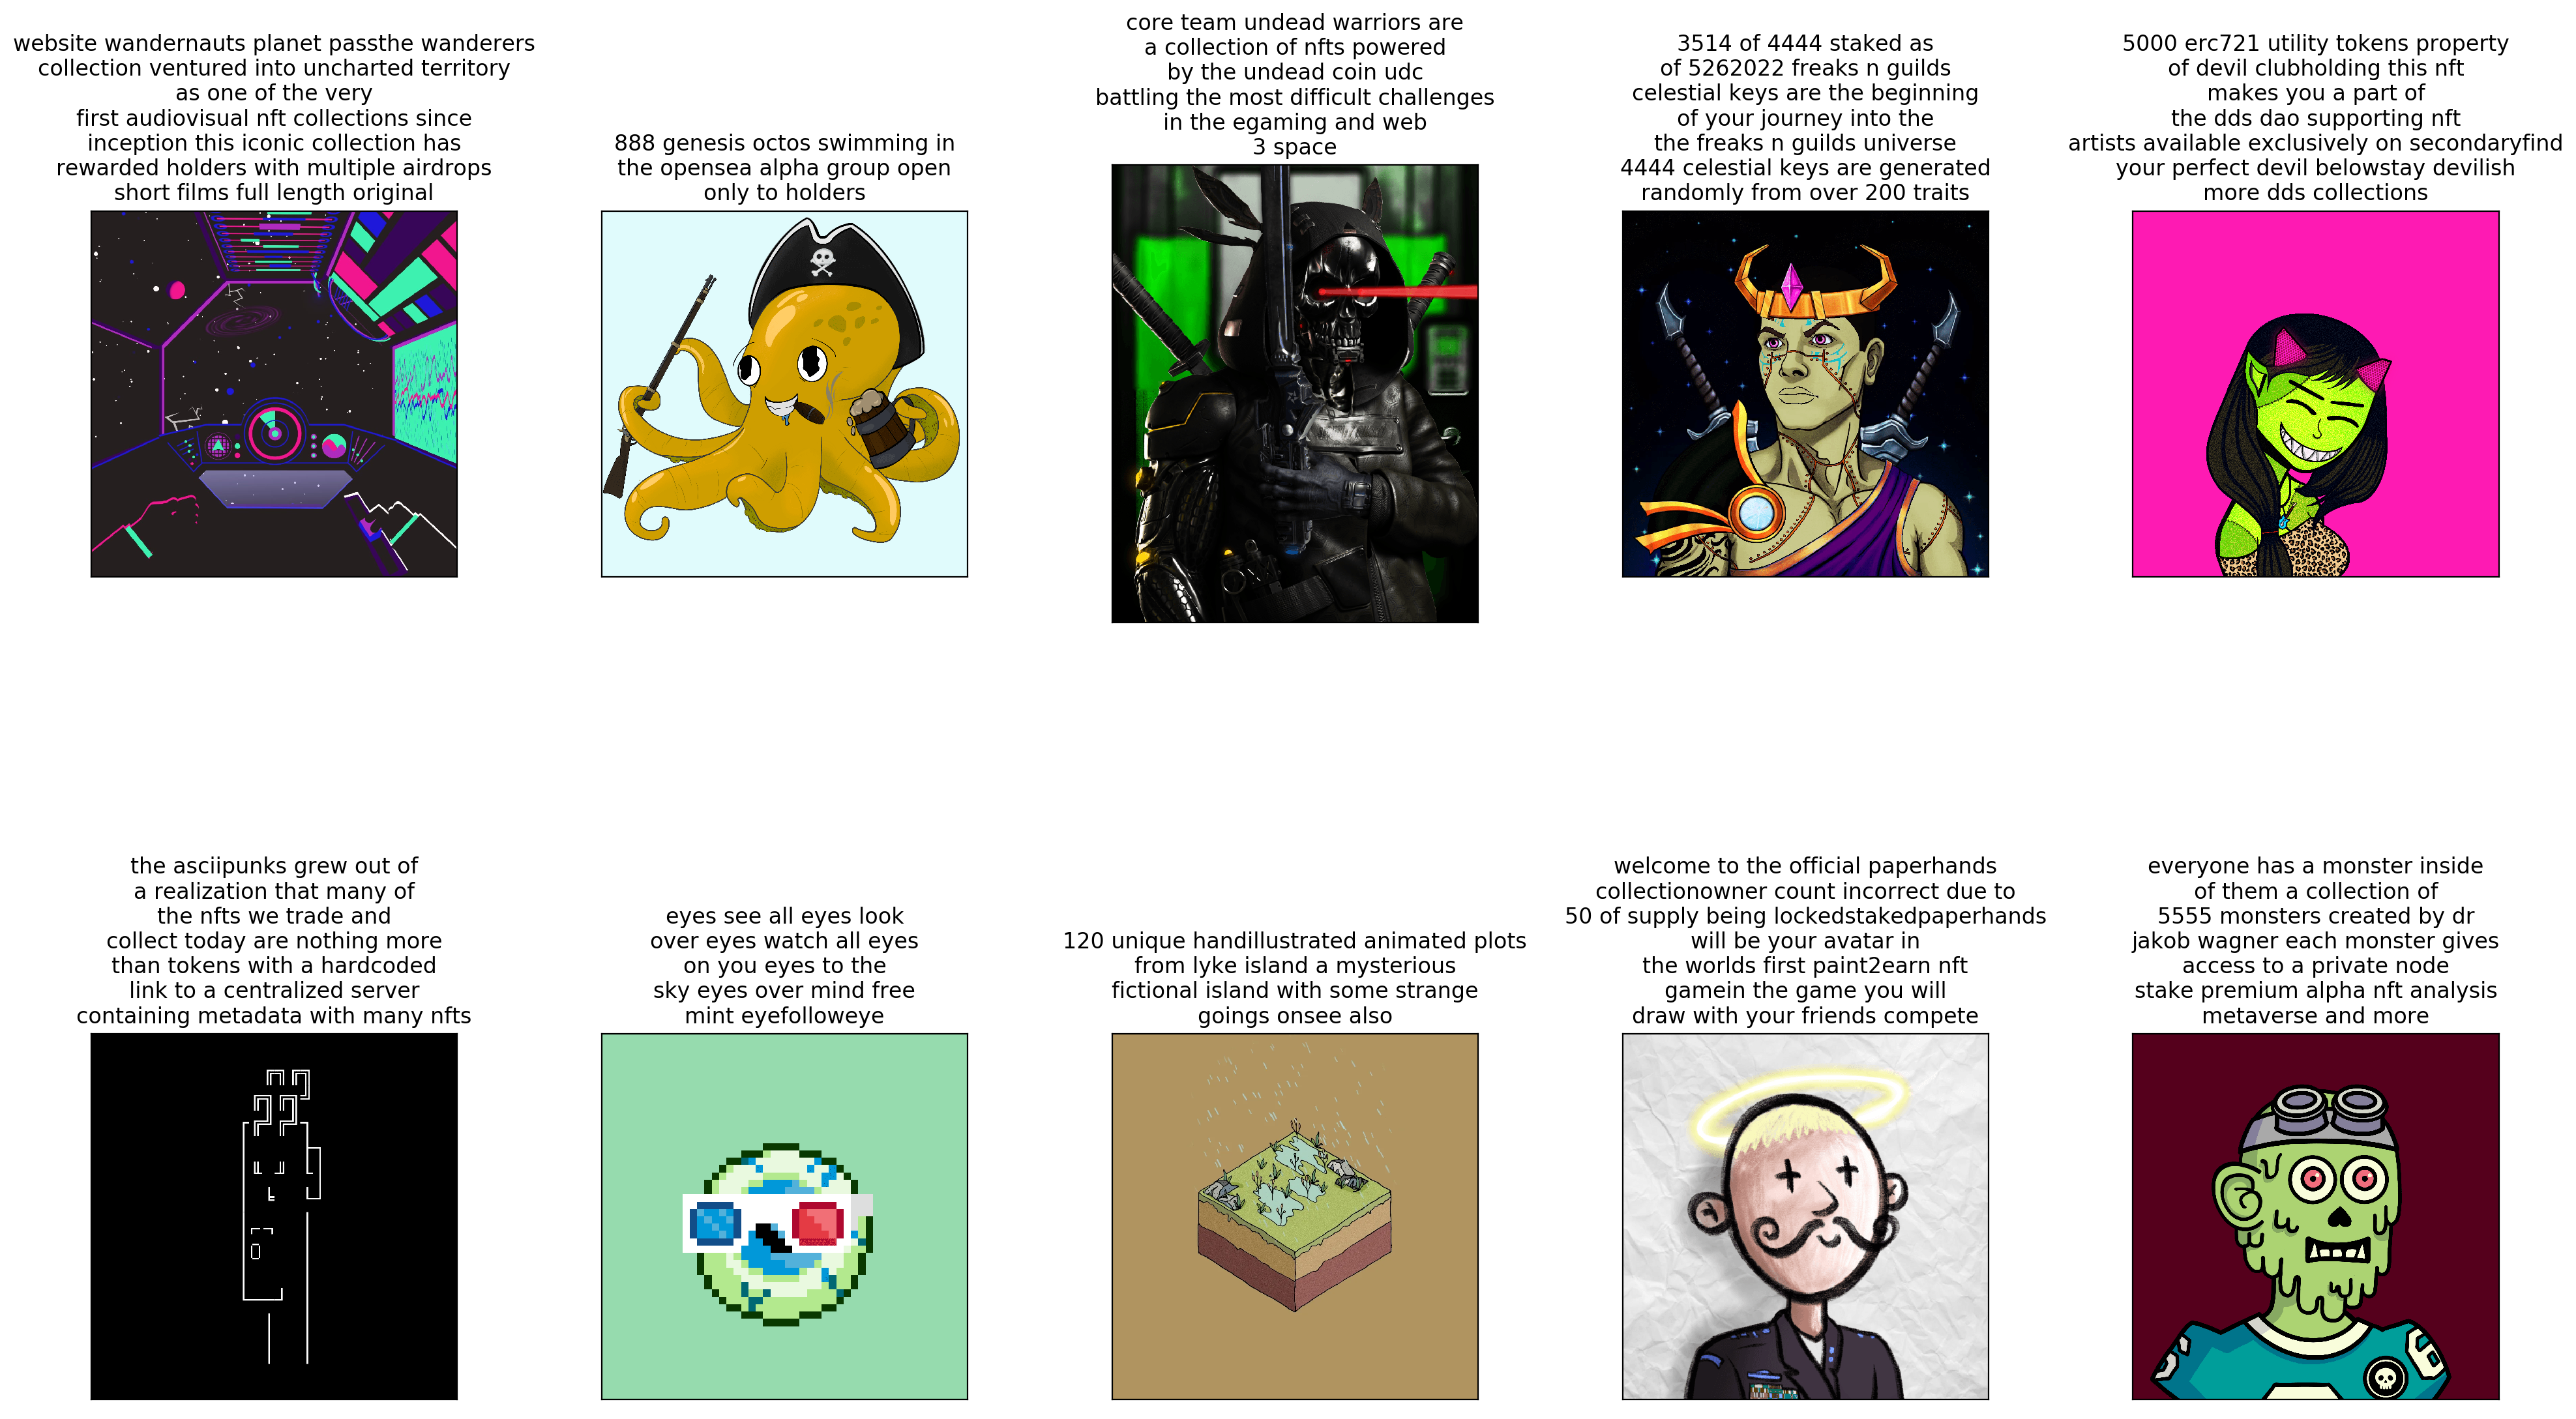

In [12]:
original_images = []
images = []
texts = []
plt.figure(figsize=(20, 14))

for i, filename in enumerate(sample_imgs):
    description = desc[i]
    with Image.open(filename) as f:
        image = f.convert("RGB")
    plt.subplot(2, 5, len(images) + 1)
    plt.imshow(image)
    
    plt.title(f"{title_formatter(description, 35)}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))

plt.tight_layout()


In [13]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(desc, truncate=True).cuda()


with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()




## Calculate Cosine Similarity and Visualize


In [14]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

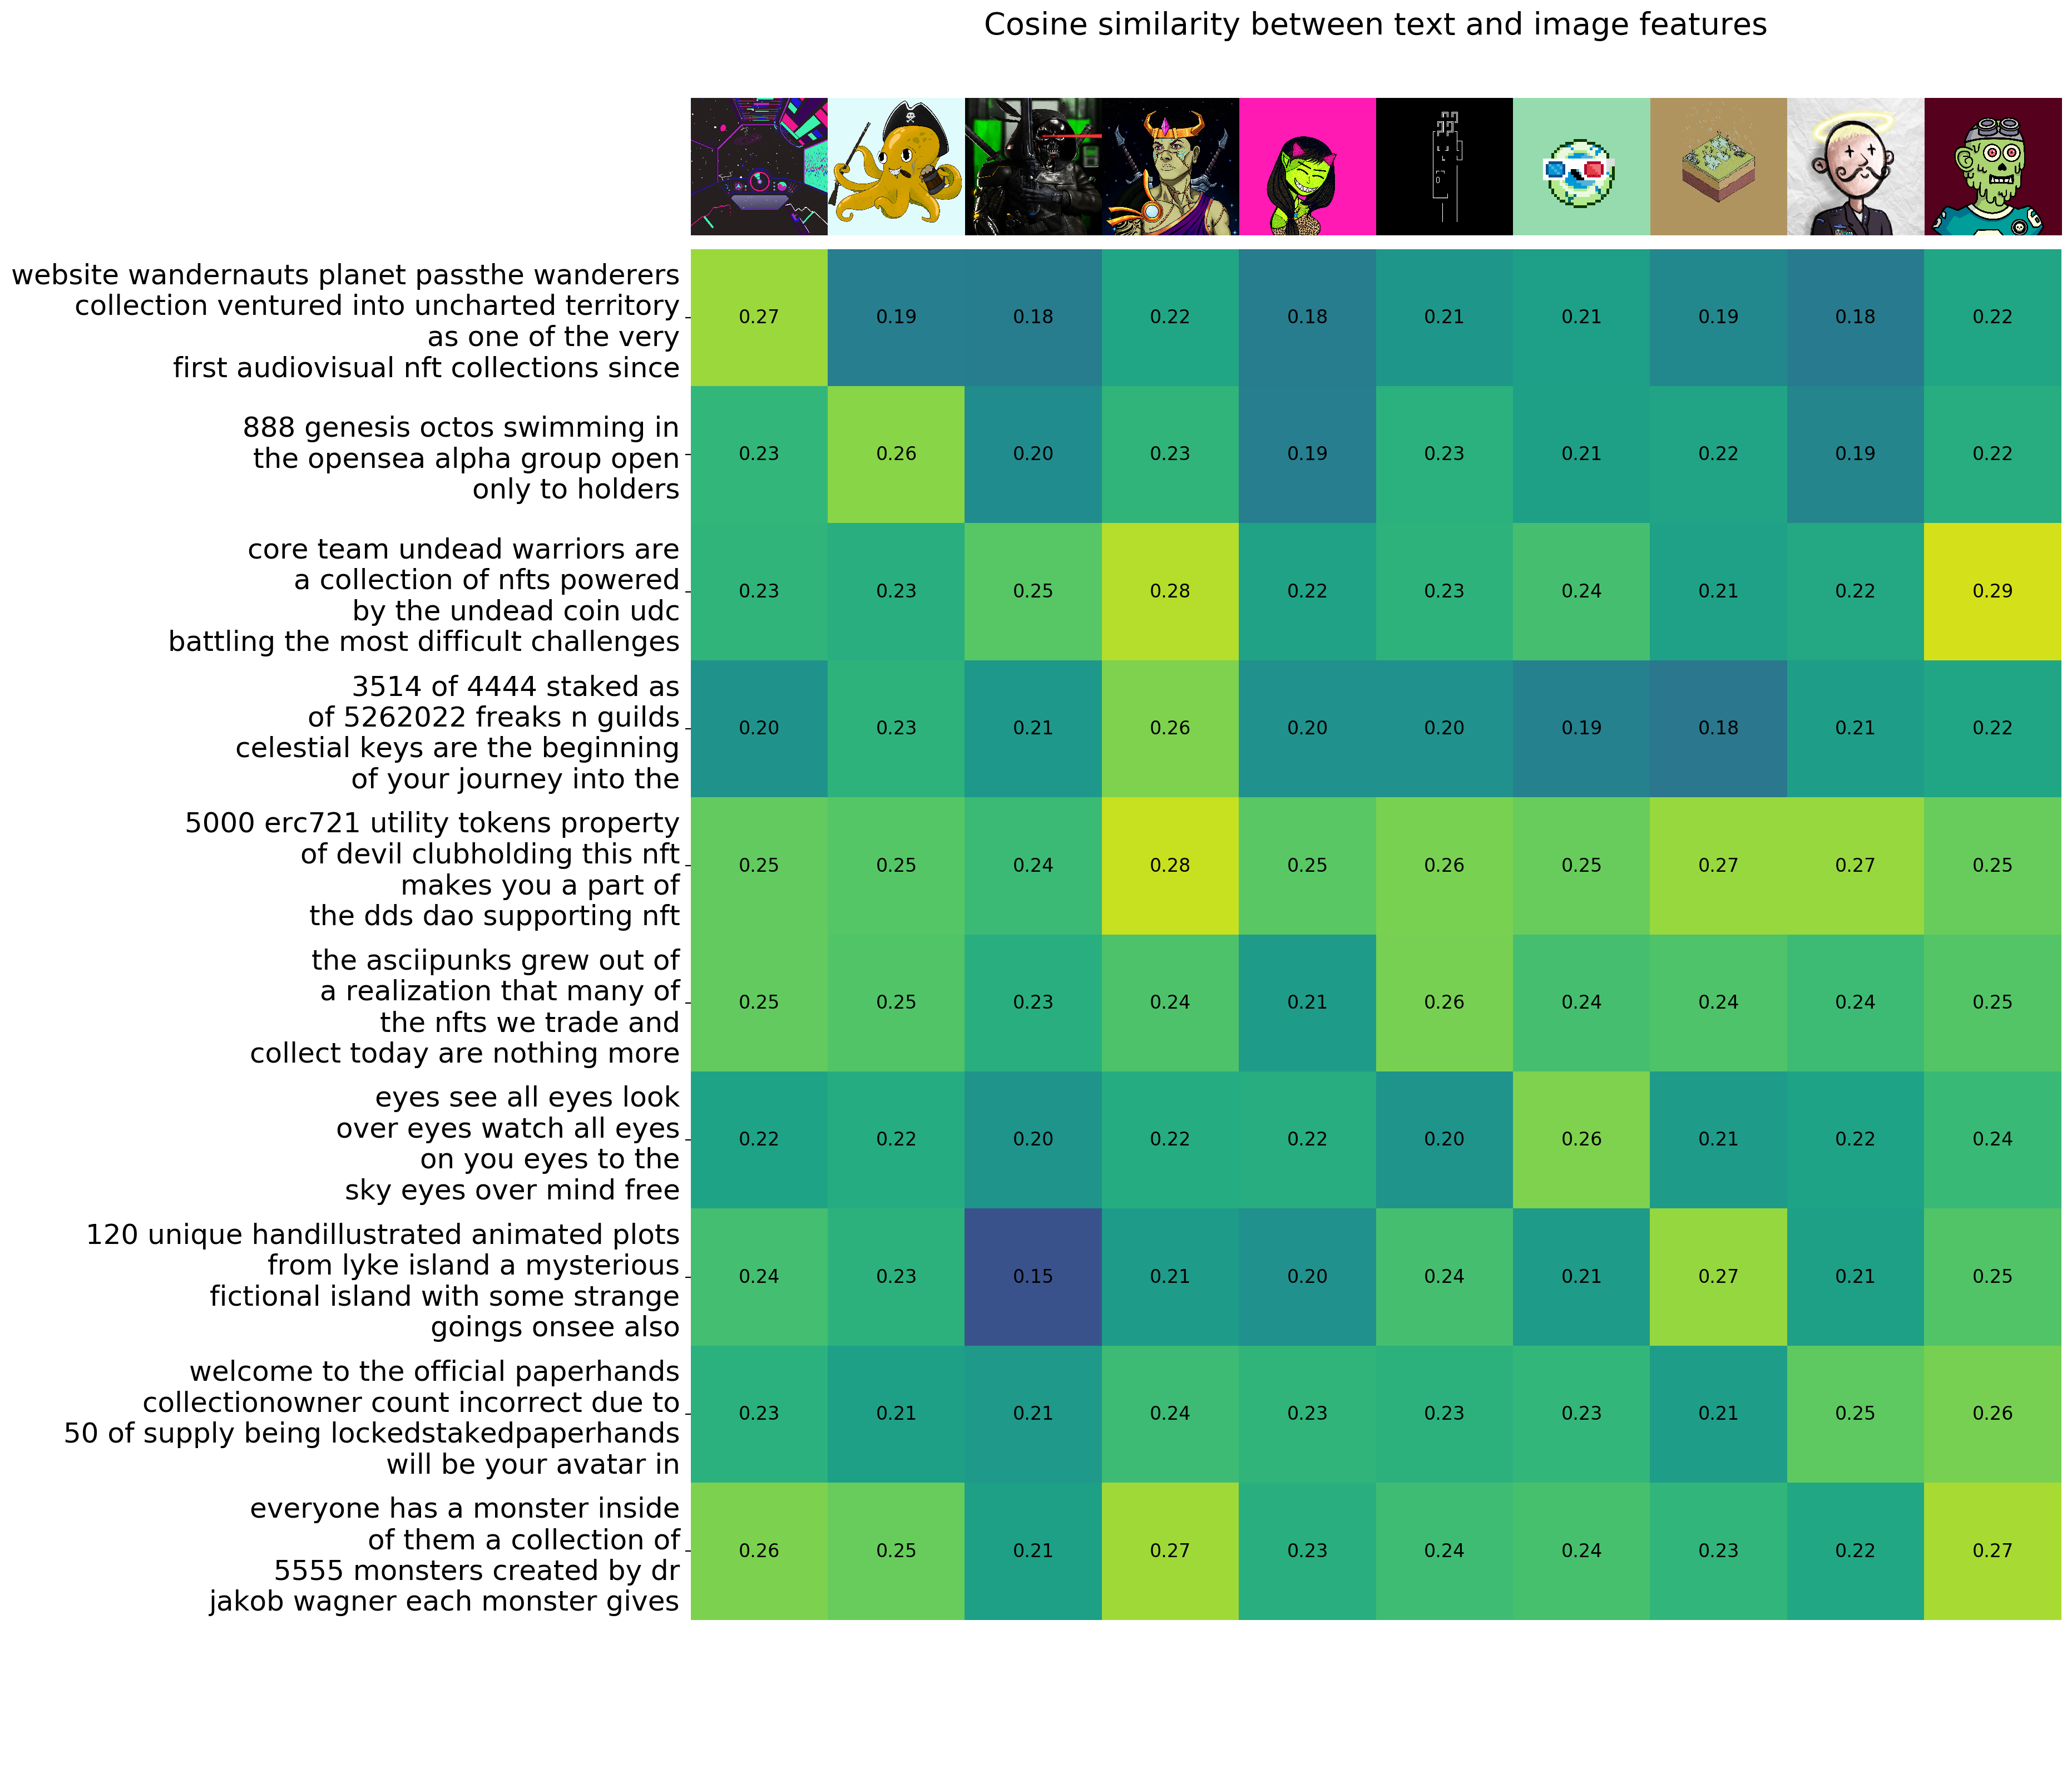

In [15]:
count = len(desc)

plt.figure(figsize=(20, 20))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), [title_formatter(d, 20) for d in desc], fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Go over all the samples

<font size = 5>**For each image, we randomly sample 4 descriptions along with 1 correct description. And we test if CLIP is able to figure out which one is correct**<font size = 5>

## Dump Vision Features

In [19]:
FEATURE_PATH = './vision_feature'
os.makedirs(FEATURE_PATH,exist_ok = True)

## TODO: There are a few invalid images from thumbnail. Might need to investigate on this later

for filename in imgs:
    contract = filename.split('/')[-1].split('.')[0]
    if os.path.exists({FEATURE_PATH}/{contract}):
        continue
    try:
        with Image.open(filename) as f:
            image = f.convert("RGB")
            post_image = preprocess(image)

            torch.save(post_image, f'{FEATURE_PATH}/{contract}')
    except Exception as e:
        print(e)


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file './thumbnail/0x95cdb0fbf3ccadabba38acc921a9b2381329f727.png'
cannot identify image file './thumbnail/0x7150cd8593670341121eee513538108029298cf7.png'
cannot identify image file './thumbnail/0x22f26d7b074391c483a9952ef2e2b8f6b208d897.png'
cannot identify image file './thumbnail/0x05a46f1e545526fb803ff974c790acea34d1f2d6.png'
cannot identify image file './thumbnail/0xf62c6a8e7bcdc96cda11bd765b40afa9ffc19ab9.png'
cannot identify image file './thumbnail/0x4f8730e0b32b04beaa5757e5aea3aef970e5b613.png'
cannot identify image file './thumbnail/0xd1e5b0ff1287aa9f9a268759062e4ab08b9dacbe.png'
cannot identify image file './thumbnail/0x69c40e500b84660cb2ab09cb9614fa2387f95f64.png'
cannot identify image file './thumbnail/0xeafa25e962ee875f75fdc97e152d39bb4c8978ae.png'
cannot identify image file './thumbnail/0x12d2d1bed91c24f878f37e66bd829ce7197e4d14.png'
cannot identify image file './thumbnail/0x60eb332bd4a0e2a9eeb3212cfdd6ef03ce4cb3b5.png'
cannot identify image file './th

In [21]:
vision_feats = glob.glob(FEATURE_PATH+'/*')
print(f'totally {len(vision_feats)} contracts has been transformed into vision features')

totally 4405 contracts has been transformed into vision features


## Random Description Generator

In [49]:
desc_full = {}
cleaned_vision_feats = []
# There are some with no description, remove them first
for feat in vision_feats:
    contract = feat.split('/')[-1]
    d = contract_df.loc[contract_df['contract_address']==contract, 'desc'].item()
    
    if type(d) == float or len(d)<10:
        continue 
    desc_full[feat] = d
    cleaned_vision_feats.append(feat)

vision_feats = cleaned_vision_feats
    
    
    

In [55]:
def generator(feat, choices = 5):
    assert choices>1, "Number of Choices Must be Greater than 1"
    correct_desc = desc_full[feat]
    while True:
        samples = sample(vision_feats, choices-1)
        if feat not in samples:
            break
        
    samples.append(feat)
    return [desc_full[d] for d in samples]
    

In [67]:
def test_instance(feat, choices = 5):
    img_input = torch.load(feat)
    img_input = torch.unsqueeze(img_input, 0).cuda()
    text_feat = generator(feat, choices)

    text_tokens = clip.tokenize(text_feat, truncate=True).cuda()
  

    with torch.no_grad():
        image_features = model.encode_image(img_input).float()
        text_features = model.encode_text(text_tokens).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    return similarity

In [72]:
from tqdm.notebook import tqdm

def calculate_acc(choices):
    correct_hits = 0
    for feat in tqdm(vision_feats):
        similarity = test_instance(feat, choices)
        # The last one is the correct pair
        correct_hits += int(np.argmax(similarity) == len(similarity)-1)
    return correct_hits/len(vision_feats)
    

In [73]:
accuracy_list = []
for i in range(2, 10):
    accuracy_list.append(calculate_acc(i))
    
    

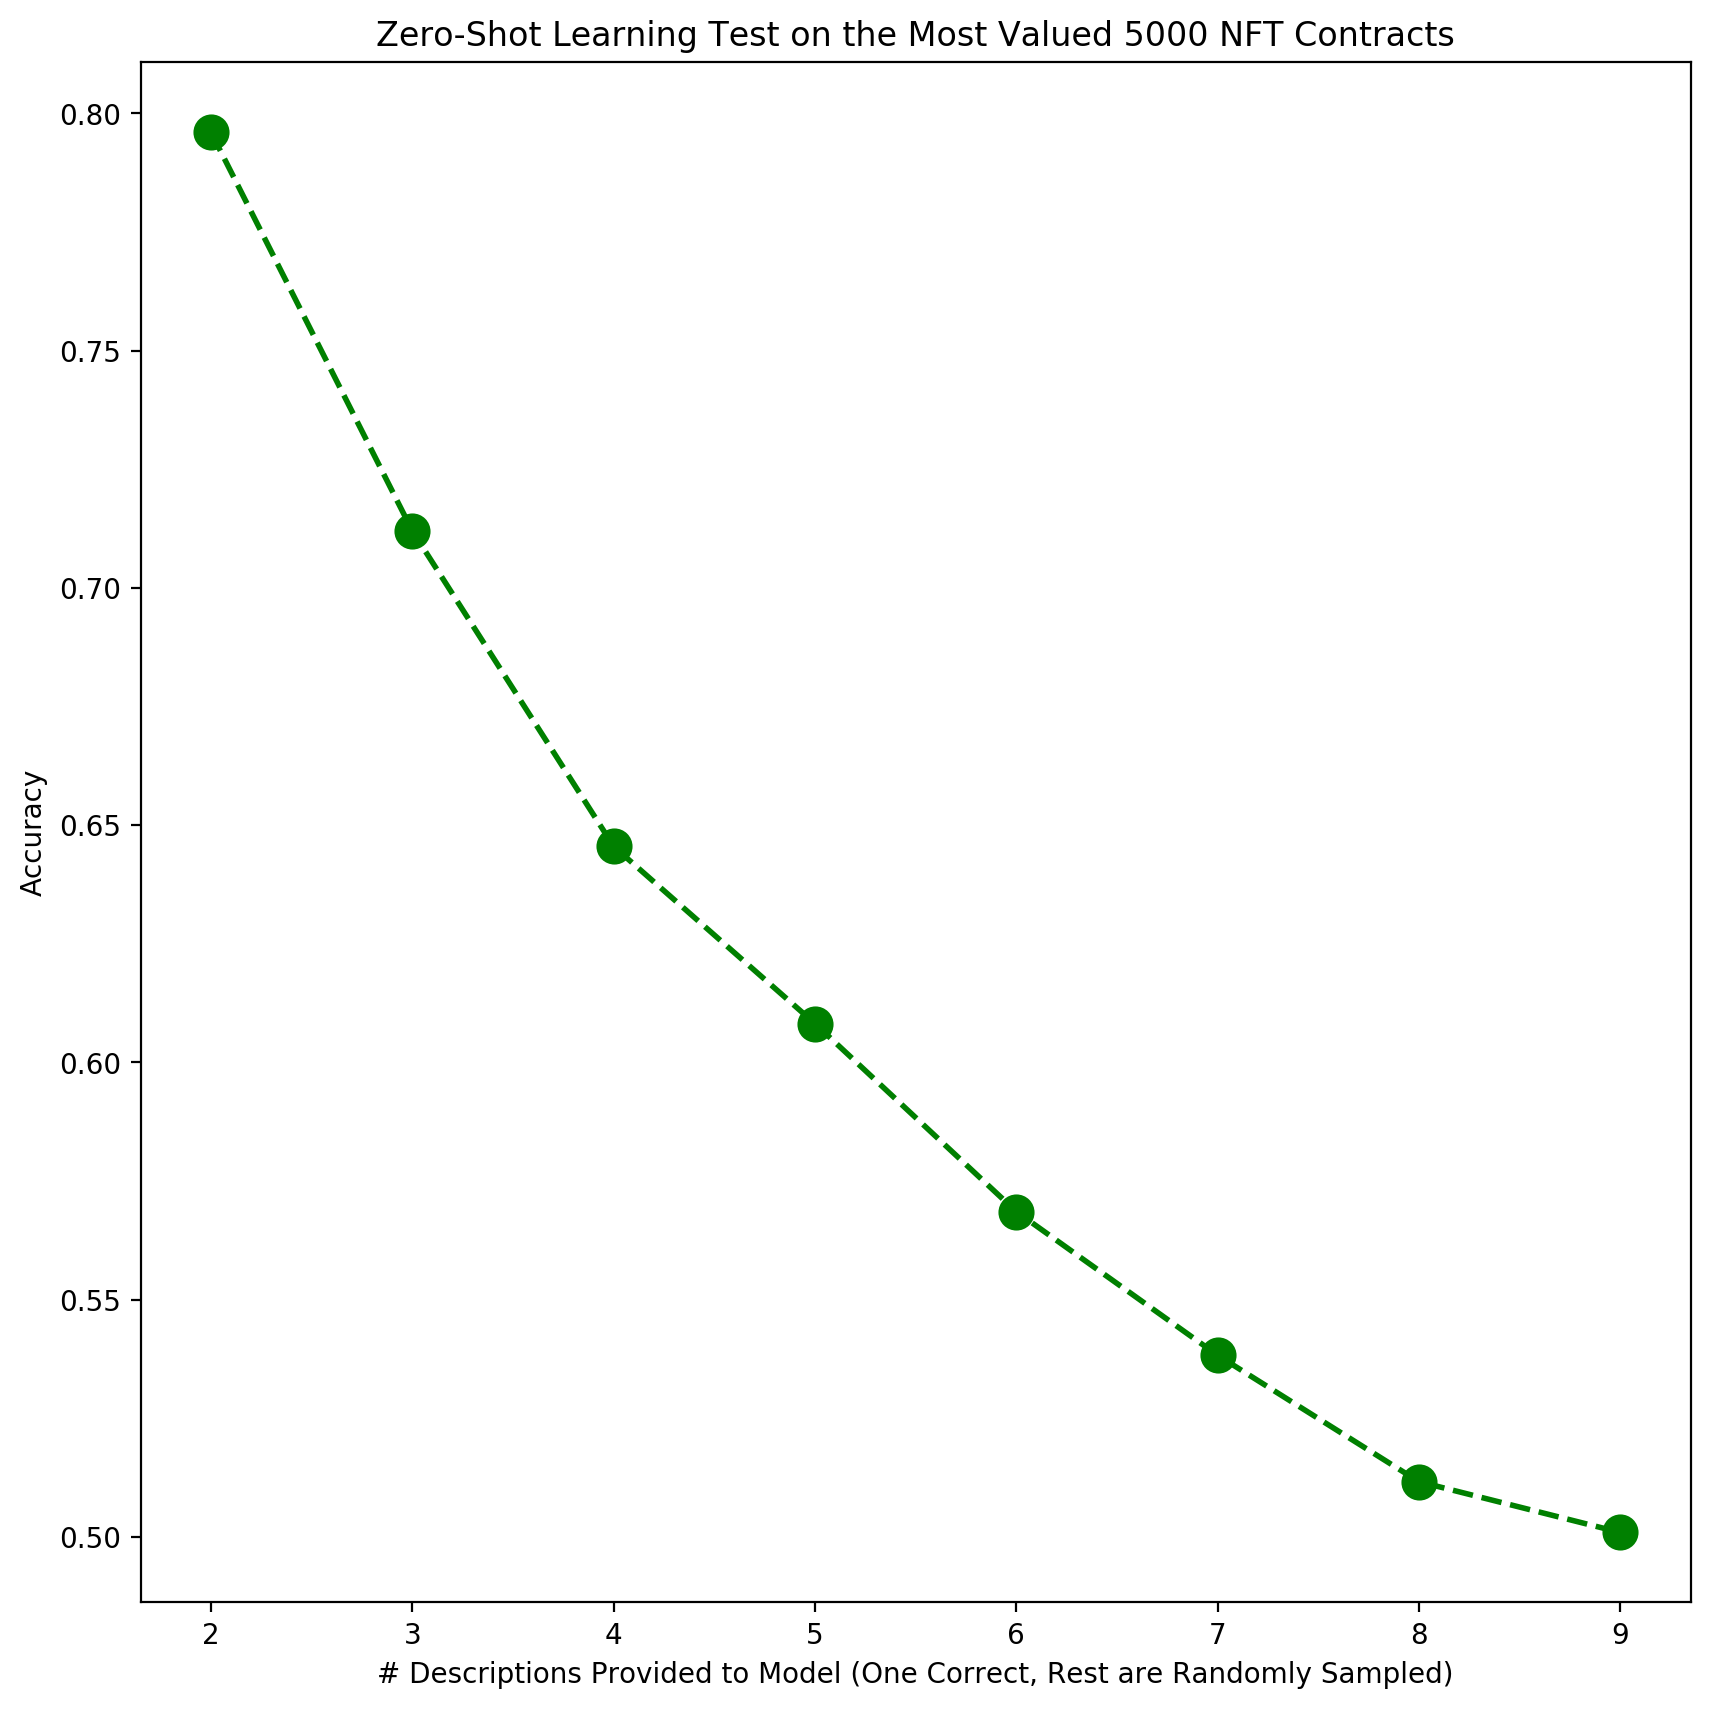

In [83]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.plot(range(2,10),accuracy_list, color='green', marker='o', linestyle='dashed',
     linewidth=2, markersize=12)

plt.title('Zero-Shot Learning Test on the Most Valued 5000 NFT Contracts')
plt.xlabel('# Descriptions Provided to Model (One Correct, Rest are Randomly Sampled)')
plt.ylabel('Accuracy')
plt.savefig('ZeroShotPerf.png')

## Prepare for model training/val

In [98]:
import json

SPLIT_RATIO = 0.85

split_idx = int(len(desc_full)*SPLIT_RATIO)
train_json = dict(list(desc_full.items())[:split_idx])
test_json = dict(list(desc_full.items())[split_idx:])

DATA_FOLDER = './data'

with open(os.path.join(DATA_FOLDER, 'train.json'), 'w') as f:
    json.dump(train_json, f)
    
with open(os.path.join(DATA_FOLDER, 'test.json'), 'w') as f:
    json.dump(test_json, f)
    
    
    